NetworkLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Chosen dataset(s): ['sine_noise']
Num. worms: 6
Worm names: ['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5']


torch.Size([3312, 302])


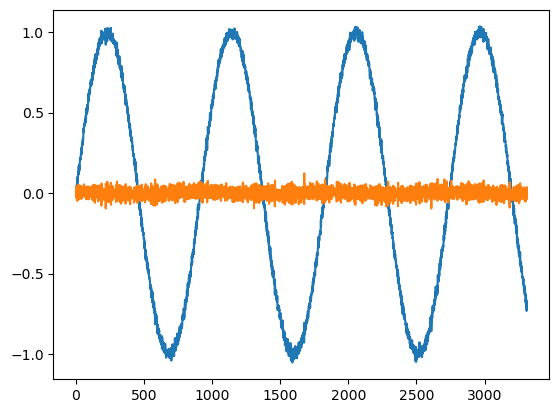

In [46]:
#!/usr/bin/env python
# encoding: utf-8
'''
@author: ivy
@contact: ivyivyzhao77@gmail.com
@software: PyCharm 2022.3
@file: script_Uzel2022_qM_iDL_qT.py
@time: 2023/3/14 11:21
'''

from train._utils import *
from models._utils import *

########################### Hyperparameters #########################
time_step = 10
BATCH_SIZE = 128
LR = 0.1
EPOCH = 100
num_worms_train = 1
CUTDOWN = 1
smoothed = False
#####################################################################

model = NetworkLSTM(CUTDOWN, 64).double()
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

dataset = get_dataset(OmegaConf.load("../../../conf/dataset.yaml"))

print(dataset["worm0"]["calcium_data"].shape)

plt.plot(dataset["worm0"]["calcium_data"][:, 1])
plt.plot(dataset["worm0"]["residual_calcium"][:, 1])
plt.show()

## Use Smoothed Data, Cal to Cal

torch.Size([3312, 1])
split: 0.5


--------worm No. 0--------


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_21306/2160186027.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_21306/2160186027.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)


epoch = 0, train_loss = 0.2267, test_loss = 0.4853
epoch = 1, train_loss = 0.2097, test_loss = 0.3825


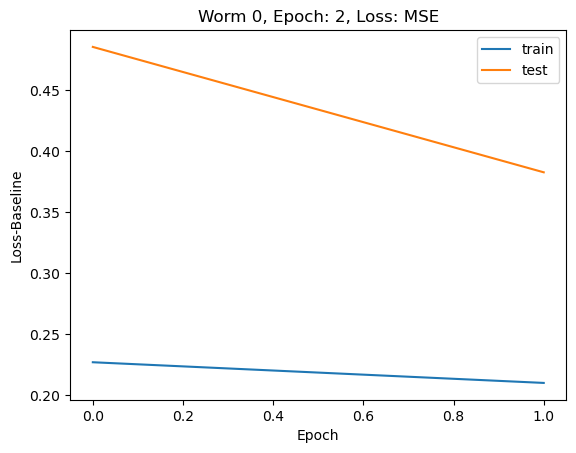

In [47]:
for k in range(num_worms_train):
    worm = "worm" + str(k)
    if smoothed:
        calcium_data = dataset[worm]["smooth_calcium_data"][:, :CUTDOWN].double()
        residual_calcium = dataset[worm]["residual_smooth_calcium"][:, :CUTDOWN].double()
    else:
        calcium_data = dataset[worm]["calcium_data"][:, :CUTDOWN].double()
        residual_calcium = dataset[worm]["residual_calcium"][:, :CUTDOWN].double()

    print(calcium_data.shape)

    cutdown = calcium_data.shape[0]
    train_size = int(0.5 * cutdown)
    print("split: 0.5")
    test_size = cutdown - train_size

    train_ca, test_ca = calcium_data.split(train_size, dim=0)
    train_res, test_res = residual_calcium.split(train_size, dim=0)

    train_loop_cal = []
    train_loop_res = []
    for i in range(0, train_ca.shape[0] - time_step):
        train_loop_res.append(np.array(train_res[i:i + time_step, :]))
        train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

    train_loop_cal = torch.tensor(np.array(train_loop_cal))
    train_loop_res = torch.tensor(np.array(train_loop_res))

    # print(train_loop_cal.shape, train_loop_res.shape)

    test_loop_cal = []
    test_loop_res = []
    for i in range(0, test_ca.shape[0] - time_step):
        test_loop_res.append(np.array(test_res[i:i + time_step, :]))
        test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

    test_loop_cal = torch.tensor(np.array(test_loop_cal))
    test_loop_res = torch.tensor(np.array(test_loop_res))

    train_loop_cal_target = torch.zeros_like(train_loop_cal)
    train_loop_cal_target[:-1] = train_loop_cal[1:]

    test_loop_cal_target = torch.zeros_like(test_loop_cal)
    test_loop_cal_target[:-1] = test_loop_cal[1:]

    train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_cal_target)
    test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_cal_target)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    print("\n")
    print("--------worm " + "No. " + str(k) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            mask_train = dataset[worm]["named_neurons_mask"][:CUTDOWN].double()
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0
            mask_train = mask_train.unsqueeze(0)
            mask_train = mask_train.repeat(Y_train.shape[0], Y_train.shape[1], 1)
            base = criterion(X_train * mask_train, Y_train * mask_train)
            Y_tr = model(X_train * mask_train)
            # Y_tr.retain_grad()
            # Y_tr.register_hook(lambda grad: grad * mask_train.float())
            loss = criterion(Y_tr * mask_train, Y_train * mask_train)
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            mask_test = dataset[worm]["named_neurons_mask"][:CUTDOWN].double()
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            mask_test = mask_test.repeat(Y_test.shape[1], 1)
            mask_test = mask_test.unsqueeze(0)
            mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(X_test * mask_test, Y_test * mask_test)
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test * mask_test)  # .transpose(1, 2))  # Forward pass.
            loss = criterion(Y_pred * mask_test, Y_test * mask_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        # print("Count = ", count)
        # print("Test X_test shape = ", X_test.shape)
        # print("Test Y_test shape = ", Y_test.shape)
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e, train_pred_loss_history[-1] -
                                                                           train_base_loss_history[-1],
                                                                           test_pred_loss_history[-1] -
                                                                           test_base_loss_history[-1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in
                   range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(k) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()

model_name = "model_LR" + str(LR) + "_E" + str(EPOCH) + ".pickle"
file = open(model_name, "wb")
torch.save(model.state_dict(), file)

In [48]:
 # if smoothed:
#     calcium_data = dataset[worm]["smooth_calcium_data"]
#     residual_calcium = dataset[worm]["residual_smooth_calcium"]
# else:
#     calcium_data = dataset[worm]["calcium_data"]
#     residual_calcium = dataset[worm]["residual_calcium"]

# file = open("model.pickle", "rb")
# model = torch.load(file)

from train._utils import *



dataset = get_dataset(OmegaConf.load("../../../conf/dataset.yaml"))

model = NetworkLSTM(CUTDOWN, 64).double()
model.load_state_dict((torch.load(model_name)))
model.eval()
calcium_data = dataset["worm0"]["calcium_data"][:, :CUTDOWN].double()

mask_test = dataset["worm0"]["named_neurons_mask"][:CUTDOWN].double()

# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []


time_step = 3310

for i in range(time_step, calcium_data.shape[0] - 1):
    X, Y = calcium_data[i - time_step:i], calcium_data[i-time_step + 1: i+1]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

print(X_test.shape, Y_test.shape, "---")

mask_test = mask_test.repeat(Y_test.shape[1], 1)
mask_test = mask_test.unsqueeze(0)
mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
# print(mask_test)
Y_test = Y_test * mask_test
Y_pred = model(X_test * mask_test)

Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

print(dataset["worm0"]["num_named_neurons"], dataset["worm0"]["num_neurons"])

count = dataset["worm0"]["named_neurons_mask"].sum()
print(count)

# count = 0
# for i in range(0, Y_test.shape[2]):
#     # print(i+count)
#     if i+count >= dataset["worm0"]["named_neurons_mask"].shape[0]: break
#     if i >= Y_test.shape[2]: break
#     if dataset["worm0"]["named_neurons_mask"][i+count].item() is False:
#         Y_test = np.delete(Y_test, i, axis=2)
#         Y_pred = np.delete(Y_pred, i, axis=2)
#         i -= 1
#         count += 1


Y_test = torch.tensor(Y_test)
Y_pred = torch.tensor(Y_pred)

print(Y_pred.shape, Y_test.shape)

Chosen dataset(s): ['sine_noise']
Num. worms: 6
Worm names: ['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5']


torch.Size([1, 3310, 1]) torch.Size([1, 3310, 1]) ---
202 302
tensor(202)
torch.Size([1, 3310, 1]) torch.Size([1, 3310, 1])


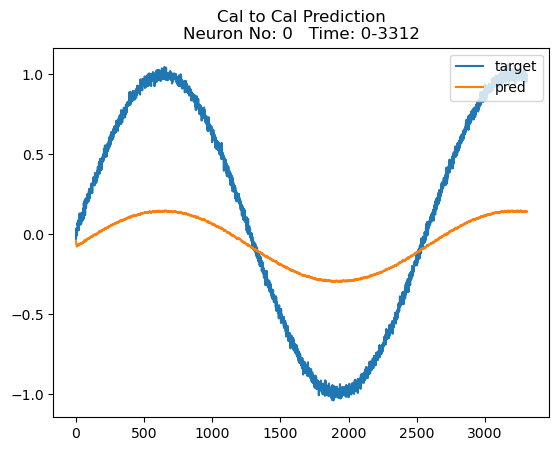

In [49]:
def draw_pic(Y_pred, Y_test, num, time):
    plt.plot(Y_test.detach().numpy()[0, :, num])
    plt.plot(Y_pred.detach().numpy()[0, :, num])
    plt.legend(["target", "pred"], loc="upper right")
    plt.title("Cal to Cal Prediction\n" + "Neuron No: " + str(num) + "   Time: 0-" + str(time))
    plt.show()



draw_pic(Y_pred, Y_test, 0, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 0, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 49, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 60, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 200, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 300, dataset["worm0"]["max_time"])


In [50]:

for i in range(6):
    # plt.plot(dataset["worm"+str(i)]["calcium_data"][:, 0])
    # plt.plot(dataset["worm"+str(i)]["calcium_data"][:, 60])
    print(dataset["worm"+str(i)]["named_neurons_mask"][0])
    print(dataset["worm"+str(i)]["named_neurons_mask"][60])
    plt.show()

tensor(True)
tensor(True)
tensor(True)
tensor(False)
tensor(True)
tensor(True)
tensor(True)
tensor(False)
tensor(True)
tensor(True)
tensor(True)
tensor(False)


In [51]:
# plt.plot(Y_test.detach().numpy()[::time_step, 0, 0])
# plt.plot(Y_pred.detach().numpy()[:, 0, 0])
# plt.show()